In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import pickle

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import (EarlyStopping,                # Checkpoints
                                      ReduceLROnPlateau,
                                      ModelCheckpoint,
                                      TensorBoard)
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split

In [3]:
cwd = os.getcwd()
datapath = os.path.join(cwd, 'datasets')

df = pd.read_excel(os.path.join(datapath, 'all_cleaned.xlsx'))
df = df[['berita', 'label']]

df.drop_duplicates(inplace=True)
df.dropna(inplace = True)

df.label.value_counts()

label
0    20944
1     6474
Name: count, dtype: int64

In [4]:
from imblearn.under_sampling import RandomUnderSampler

X = df[['berita']]
y = df['label']
rus = RandomUnderSampler(random_state=1, replacement=True)# fit predictor and target variable
X_new, y_new = rus.fit_resample(X,y)
y_new.value_counts()

label
0    6474
1    6474
Name: count, dtype: int64

In [5]:
list(X['berita'].values)

['anies milad bkmt aji hasil ibu ibu tahu mantan gubernur dki jakarta anies baswedan hadir acara tasyakur milad tahun badan kontak majelis taklim bkmt istora senayan jakarta selasa pun puji eksistensi ibu ibu aji wujud hasil didik keluarga kata lama tahun usia bkmt jadi teladan hasil didik keluarga bkmt kata jadi bukti aji hasil ibu ibu lebih tahu bkmt jadi bukti aji hasil ibu ibu lebih tahu ibu ibu punya bekal didik anak anak buat rumah cermin nilai islam akhlak baik kata anies kutip unggah akun media sosial instagram milik unggah anies singgung soal bkmt tidak lepas sosok tuty alawiyah turut anies tuty bukan orang ustazah mampu pimpin ratus majelis taklim hingga jadi bkmt jangkau seluruh indonesia juga orang ibu hebat didik anak anak kami kenal prof dailami firdaus para saudara rupa pribadi pribadi hasil bidang tak juga guyub saling support tulis anies foto momen diri milad bkmt istora senayan itu tampak hadir jumlah tokoh politik jabat negara beberapa antara lihat foto unggah instag

In [6]:
gensim_path = os.path.join(cwd, 'models', 'id_word2vec1')
path = os.path.join(gensim_path, 'idwiki_word2vec_100.model')
model = gensim.models.word2vec.Word2Vec.load(path)

# model.build_vocab(list(X['berita'].values), update=True)
# model.train(list(X['berita'].values), total_examples=model.corpus_count, epochs=model.epochs)  

In [7]:
word_vectors = model.wv
word_vectors.save(os.path.join(gensim_path, "word2vec.wordvectors"))

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load(os.path.join(gensim_path, "word2vec.wordvectors"), mmap='r')

vector = wv['computer']  # Get numpy vector of a word

In [8]:
EMBEDDING_DIM = vector.shape[0]

In [9]:
wv.most_similar(positive=["trump","obama", "clinton"])

[('barack', 0.8371595740318298),
 ('bush', 0.8285682201385498),
 ('eisenhower', 0.774006187915802),
 ('nixon', 0.756653904914856),
 ('hillary', 0.7557528018951416),
 ('roosevelt', 0.7513755559921265),
 ('kennedy', 0.7318629622459412),
 ('reagan', 0.7303686738014221),
 ('truman', 0.6974683403968811),
 ('sirleaf', 0.6836060285568237)]

In [10]:
vector

memmap([ 1.2204375 , -0.67172676,  0.8706311 , -0.3214097 ,  1.6194834 ,
         2.6867278 , -1.1567526 ,  1.3310935 ,  1.9045293 ,  0.22121091,
         2.9144907 ,  0.5889447 , -0.6142227 ,  0.68973714, -2.7251358 ,
        -0.55758786,  2.1523018 ,  0.5798573 ,  0.06600937,  1.9846426 ,
         2.1649754 ,  0.18753484,  0.341044  ,  1.3592916 ,  0.19112888,
         0.13881932,  1.3028588 ,  0.722472  ,  0.32449618,  0.7494065 ,
        -0.6806337 ,  3.6851928 , -0.24260893,  1.5448685 , -2.016036  ,
         0.8716766 , -1.6695402 ,  0.8824429 ,  2.0015223 ,  0.8149695 ,
        -0.49070042, -3.9732673 , -3.2722168 , -0.88745546,  4.3715787 ,
        -0.54230547, -2.0044103 ,  0.48366725,  0.07059179, -0.814773  ,
        -1.656231  , -0.43804836,  1.1815835 ,  2.8230362 , -0.7802094 ,
         1.0965507 ,  0.5444713 ,  0.49926427,  0.17399307, -0.00961051,
         1.2367394 , -2.267702  ,  0.5827625 ,  1.2338997 ,  2.0050666 ,
         0.12632008,  2.0186265 ,  1.5115268 , -1.6

In [11]:
len(wv)

331792

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X['berita'], y, test_size=0.2, random_state=1000)
len(X_train)

21934

In [13]:
tokenizer = Tokenizer(num_words = 10000+1, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ', oov_token='UNK')
tokenizer.fit_on_texts(X_train)

X_train_tokened = tokenizer.texts_to_sequences(X_train)
X_test_tokened = tokenizer.texts_to_sequences(X_test)


In [14]:
# X_train_tokened = tokenizer.texts_to_sequences(X_train)
# X_test_tokened = tokenizer.texts_to_sequences(X_test)

In [15]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Loading tokenizer 
'''
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
'''

"\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n"

In [16]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

UNK -> 1
kata -> 2
partai -> 3
sebut -> 4
jadi -> 5
politik -> 6
presiden -> 7
bagai -> 8
jokowi -> 9
ketua -> 10


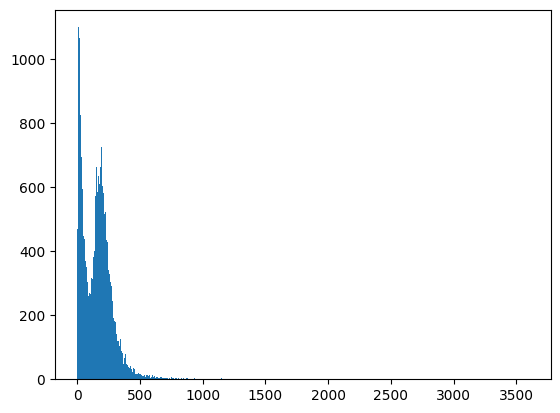

In [17]:
plt.hist([len(x) for x in X_train_tokened], bins=500)
plt.show()

In [18]:
nos = np.array([len(x) for x in X_train_tokened])
len(X_train_tokened), len(nos[nos  < 500])

(21934, 21558)

In [19]:
maxlen = 500 
vocab_size = list(word_index.values())[-1] + 1

#Making all news of size maxlen defined above
X_train_tokened = pad_sequences(X_train_tokened, maxlen=maxlen)
X_test_tokened = pad_sequences(X_test_tokened, maxlen=maxlen)


In [20]:
X_train_tokened[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [21]:
len(X_train_tokened[0])

500

In [22]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = list(vocab.values())[-1] + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model[word]
        except:
            weight_matrix[i] = np.zeros((EMBEDDING_DIM))
    return weight_matrix

In [23]:
wv['sebut']

memmap([ 0.5818855 ,  1.230008  ,  0.5421281 ,  0.44840083, -0.09878816,
         4.0551367 , -2.7215116 ,  0.6825872 ,  1.0397488 , -0.5921188 ,
        -0.5742749 , -0.63160896,  1.6805942 , -0.60763055, -1.8706621 ,
        -1.6005893 , -0.5983311 ,  0.82457566, -1.3785462 , -0.3872325 ,
         1.1581025 , -3.1133363 ,  3.180437  , -0.39112252,  1.0683793 ,
        -1.0788918 , -2.432331  ,  2.325532  , -0.36715952, -2.5325837 ,
        -1.011227  ,  0.4473371 , -1.124329  , -0.4145577 , -1.3346411 ,
        -2.5378394 , -2.661166  , -2.0832362 , -1.0144465 ,  0.4392717 ,
        -1.6422453 , -1.923282  , -0.36672008,  0.48769563, -0.8856695 ,
        -1.2249074 ,  0.13000943,  0.7324278 , -0.12873931, -0.5337557 ,
         1.0795376 ,  0.27072912, -1.5805367 , -0.09774956,  0.1918112 ,
        -0.7784464 ,  1.1867296 , -2.3532085 , -0.6580214 ,  3.4041867 ,
         1.8513108 , -2.025851  ,  1.2930332 , -4.9913187 , -3.0659885 ,
        -1.252224  ,  0.14116122, -0.45405737,  2.1

In [24]:
list(word_index)[0]

'UNK'

In [25]:
embedding_vectors = get_weight_matrix(wv, word_index)

In [26]:
embedding_vectors[2]

array([-0.27099258,  1.98630714,  2.96571898, -0.77653217, -0.92021394,
        4.31680775, -2.40130019, -2.8073597 , -2.61900544,  2.59072828,
       -0.7883324 , -0.90576631, -1.00429261,  1.3362534 , -0.98468041,
        2.00056553,  3.00061703,  3.13695502, -2.2169311 , -1.34573376,
        1.21680427,  0.42452583, -1.39727426,  1.24955666,  1.47131491,
        3.02636218, -1.41590548,  1.19267416,  2.80890393, -4.3085556 ,
       -2.47517991, -3.82674789,  0.5005517 ,  1.29792726,  0.64232481,
       -0.85037041, -3.0908432 ,  3.16733289,  1.01375449,  0.31258532,
        1.66887176, -1.2788018 ,  1.17900598, -4.30204773, -1.59528422,
        1.39085639, -2.63382936,  1.88588381, -1.12149656,  0.67140234,
       -1.45505953, -0.12293468,  2.33938575,  0.64823651, -1.98650908,
       -1.63867664,  1.38061273,  2.51338243, -0.3141157 ,  2.04020309,
       -1.39775467, -0.93482924,  5.24091864, -0.98073894, -4.95851707,
       -2.46293998, -2.18281102, -1.36615181,  2.44129658,  0.90

In [27]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False, name = '1st_layer'))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25,  name = '2nd_layer')))
# BILSTM layer - 64 Neuron (units) - 3rd layer
model.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1,  name = '3rd_layer')))
model.add(Dense(units = 32 , activation = 'relu',  name = '4th_layer'))
model.add(Dense(1, activation='sigmoid', name='output_layer'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# del embedding_vectors

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_layer (Embedding)       (None, 500, 100)          6118000   
                                                                 
 bidirectional (Bidirection  (None, 500, 256)          234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 4th_layer (Dense)           (None, 32)                4128      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 6521009 (24.88 MB)
Trainable params: 40300

In [29]:
earlystop = EarlyStopping(monitor='val_loss',patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                            ) 
filepath="fake_news_bidirectional_glove.h5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir='./logs')
callbacks = [earlystop,learning_rate_reduction,checkpoint,tensorboard] 

In [30]:
model.fit(X_train_tokened, y_train, validation_data=(X_test_tokened, y_test), epochs=2, callbacks=callbacks, verbose=1, batch_size=32)

Epoch 1/2
686/686 [==============================] - 11937s 17s/step - loss: 0.1239 - acc: 0.9547 - val_loss: 0.0908 - val_acc: 0.9721 - lr: 0.0010
Epoch 2/2
686/686 [==============================] - 11825s 17s/step - loss: 0.0723 - acc: 0.9754 - val_loss: 0.0675 - val_acc: 0.9767 - lr: 0.0010


In [34]:
y_pred = model.predict(X_test_tokened) >= 0.5).astype("int")

172/172 [==============================] - 150s 855ms/step


In [36]:
model.save('lstm_model.keras')

In [45]:
import tensorflow as tf

load_model = tf.keras.models.load_model('models/lstm_model.keras')

In [40]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_layer (Embedding)       (None, 500, 100)          6118000   
                                                                 
 bidirectional (Bidirection  (None, 500, 256)          234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 4th_layer (Dense)           (None, 32)                4128      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 6521009 (24.88 MB)
Trainable params: 40300

In [41]:
import joblib

joblib.dump(model, 'lstm_model.joblib')

['lstm_model.joblib']

In [1]:
import joblib
test_model = joblib.load('lstm_model.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'lstm_model.joblib'

In [46]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_layer (Embedding)       (None, 500, 100)          6118000   
                                                                 
 bidirectional (Bidirection  (None, 500, 256)          234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 4th_layer (Dense)           (None, 32)                4128      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 6521009 (24.88 MB)
Trainable params: 40300